## 2.2 Import relevant libraries

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import montage
from tqdm import tqdm, tqdm_notebook # for progress bar
tqdm.pandas() # instantiate

import cv2

## 2.3 Read saved data

In [7]:
image_df_train = (pd.read_csv('./data/training_dataset.csv')).drop('Unnamed: 0', axis=1)
image_df_val = (pd.read_csv('./data/validation_dataset.csv')).drop('Unnamed: 0', axis=1)
image_df_test = (pd.read_csv('./data/test_dataset.csv')).drop('Unnamed: 0', axis=1)

In [8]:
image_df_test.shape,image_df_train.shape,image_df_val.shape

((11000, 6), (10000, 6), (2000, 6))

In [9]:
# pd.set_option('display.max_colwidth',None)
pd.reset_option('^display.', silent=True)
image_df_test.head()

path  damage    data_split  \
0  raw_data/test_another/damage/-96.86103_28.3637...  damage  test_another   
1  raw_data/test_another/damage/-96.891574_28.364...  damage  test_another   
2  raw_data/test_another/damage/-96.861869_28.364...  damage  test_another   
3  raw_data/test_another/damage/-96.8745319999999...  damage  test_another   
4  raw_data/test_another/damage/-96.874309_28.372...  damage  test_another   

                        location        lon        lat  
0            -96.86103_28.363781 -96.861030  28.363781  
1           -96.891574_28.364215 -96.891574  28.364215  
2           -96.861869_28.364221 -96.861869  28.364221  
3   -96.87453199999999_28.371883 -96.874532  28.371883  
4  -96.874309_28.372196000000002 -96.874309  28.372196

In [10]:
image_df_test.columns

Index(['path', 'damage', 'data_split', 'location', 'lon', 'lat'], dtype='object')

In [11]:
# Convert to gray scale using skimage rgb2gray and using PIL Image
image_df_test_gray = rgb2gray(imread(os.getcwd() +'/'+ image_df_test['path'].iloc[0]))
img2 = Image.open(os.getcwd() +'/'+ image_df_test['path'].iloc[0]).convert('L')

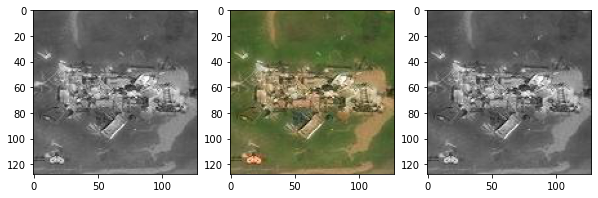

In [12]:
fig,ax = plt.subplots(1,3, figsize=(10,10))
# ax=ax[0]
ax[0].imshow(image_df_test_gray,cmap='gray')
# ax=ax[1]
ax[1].imshow(imread(os.getcwd() +'/'+ image_df_test['path'].iloc[0]))
ax[2].imshow(img2,cmap='gray')

In [13]:
image_df_test_gray.shape,(imread(os.getcwd() +'/'+ image_df_test['path'].iloc[0])).shape, img2.size

((128, 128), (128, 128, 3), (128, 128))

In [14]:
img2.size

(128, 128)

Consistent image size is crucial for deep learning, mismatched matrices will bring your project to a quick stop. Visualizing raw image size can also help you understand your dataset better.

In [15]:
def GetSize(df):
    
    df_size = pd.DataFrame()
    height = []
    width = []
    channel = []
    for i in range(len(df)):
        h,w,c = (imread(os.getcwd() +'/'+ df['path'].iloc[i])).shape
        
        height.append(h)
        width.append(w)
        channel.append(c)
        
    df_size['height'] = height
    df_size['width'] = width
    df_size['channel'] = channel
    
    return df_size

In [16]:
# get the size of each data type
test_df_size = GetSize(image_df_test)
train_df_size = GetSize(image_df_train)
val_df_size = GetSize(image_df_val)

In [17]:
test_df_size.describe().T

count   mean  std    min    25%    50%    75%    max
height   11000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
width    11000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
channel  11000.0    3.0  0.0    3.0    3.0    3.0    3.0    3.0

In [18]:
train_df_size.describe().T

count   mean  std    min    25%    50%    75%    max
height   10000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
width    10000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
channel  10000.0    3.0  0.0    3.0    3.0    3.0    3.0    3.0

In [19]:
val_df_size.describe().T

count   mean  std    min    25%    50%    75%    max
height   2000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
width    2000.0  128.0  0.0  128.0  128.0  128.0  128.0  128.0
channel  2000.0    3.0  0.0    3.0    3.0    3.0    3.0    3.0

All our datasets have similar image size, which is 128x128x3.

## 2.4 Feature extraction

In this section we will extract some features.

As shown above,all the images are color images with size 128x128, which means we have 2^8^3 different colors. We can reduce the number of colors without completely wiping-out the features

### 2.4.1 Color features

In [20]:
image_full_col = Image.open(image_df_test['path'].iloc[10408])
web_image = image_full_col.convert('P', palette='WEB', dither=None)
image_few_col = web_image.convert('RGB')

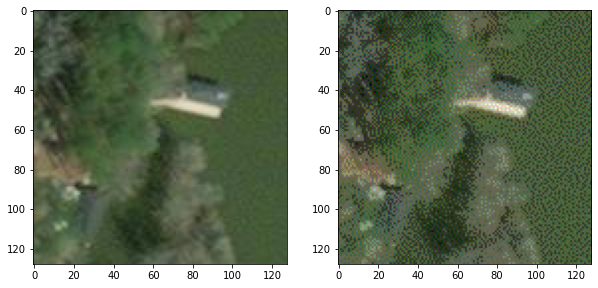

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_full_col)
ax[1].imshow(image_few_col)

In [22]:
print('Unique colors before', len(set([tuple(rgb) for rgb in np.array(image_full_col).reshape((-1, 3))])))
print('Unique colors after', len(set([tuple(rgb) for rgb in np.array(image_few_col).reshape((-1, 3))])))

Unique colors before 6126
Unique colors after 39


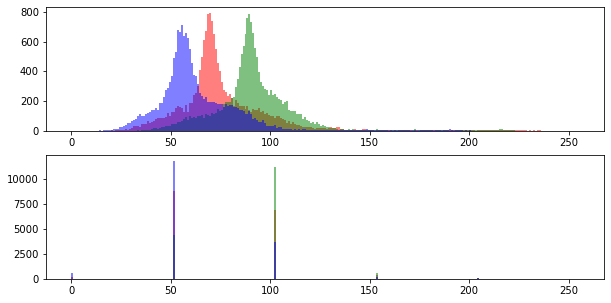

In [23]:
# Plot histrogram of the colors

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
for c_channel, c_name in enumerate(['red', 'green', 'blue']):
    ax[0].hist(np.array(image_full_col)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)
    ax[1].hist(np.array(image_few_col)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)

Text(0, 0.5, 'Pixel Count')

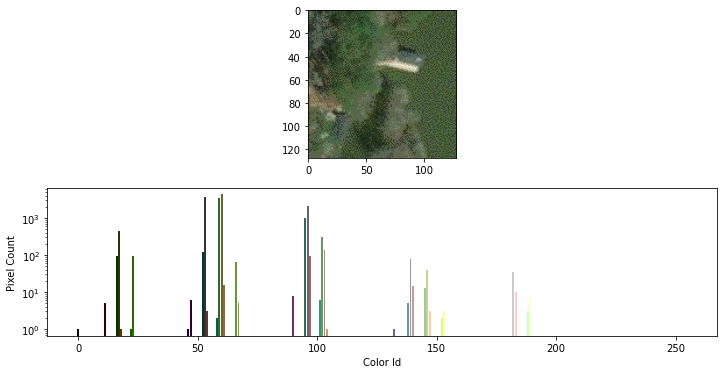

In [24]:
idx_to_color = np.array(web_image.getpalette()).reshape((-1, 3))/255.0

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(image_few_col)
counts, bins = np.histogram(web_image, bins=np.arange(256))
for i in range(counts.shape[0]):
    ax[1].bar(bins[i], counts[i], color=idx_to_color[i])
ax[1].set_yscale('log')
ax[1].set_xlabel('Color Id')
ax[1].set_ylabel('Pixel Count')

In [25]:
def color_count_feature(in_path):
    raw_image = Image.open(in_path) 
    web_image = raw_image.convert('P', palette='WEB', dither=None)
    counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
    return counts*1.0/np.prod(web_image.size) # normalize output

In [26]:
%%time
image_df_test['color_features'] = image_df_test['path'].progress_map(color_count_feature)
image_df_val['color_features'] = image_df_val['path'].progress_map(color_count_feature)
image_df_train['color_features'] = image_df_train['path'].progress_map(color_count_feature)

100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 420.71it/s]

CPU times: user 44.8 s, sys: 4.1 s, total: 48.9 s
Wall time: 54.5 s


In [28]:
# merge all images into one df for now
image_df_all = pd.concat([image_df_test,image_df_val,image_df_train], axis=0)

In [29]:
image_df_all.shape

(23000, 7)

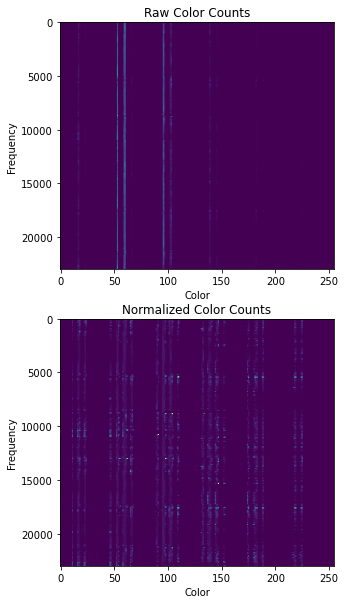

In [109]:
# image_df_test.head()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
combined_col_features = np.stack(image_df_all['color_features'].values, 0)
ax[0].imshow(combined_col_features)
ax[0].set_title('Raw Color Counts')
ax[0].set_xlabel('Color')
ax[0].set_ylabel('Frequency')
ax[0].set_aspect(0.01)
color_wise_average = np.tile(np.mean(combined_col_features, 0, keepdims=True), (combined_col_features.shape[0], 1)).clip(1/(128*128), 1)
ax[1].imshow(combined_col_features/color_wise_average, vmin=0.05, vmax=20)
ax[1].set_title('Normalized Color Counts')
ax[1].set_xlabel('Color')
ax[1].set_ylabel('Frequency')
ax[1].set_aspect(0.01)

In [110]:
from sklearn.decomposition import PCA
xy_pca = PCA(n_components=2)
xy_coords = xy_pca.fit_transform(combined_col_features)
image_df_all['x'] = xy_coords[:, 0]
image_df_all['y'] = xy_coords[:, 1]

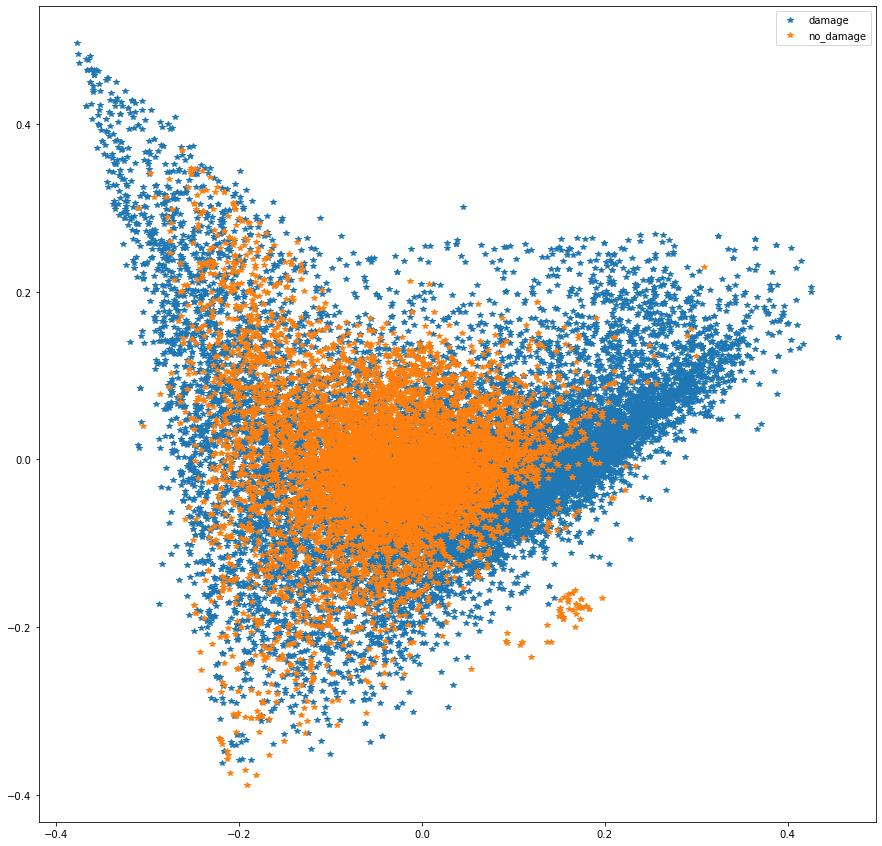

In [111]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))
for c_group, c_row in image_df_all.groupby('damage'):
    ax.plot(c_row['x'], c_row['y'], '*', label=c_group)
ax.legend()

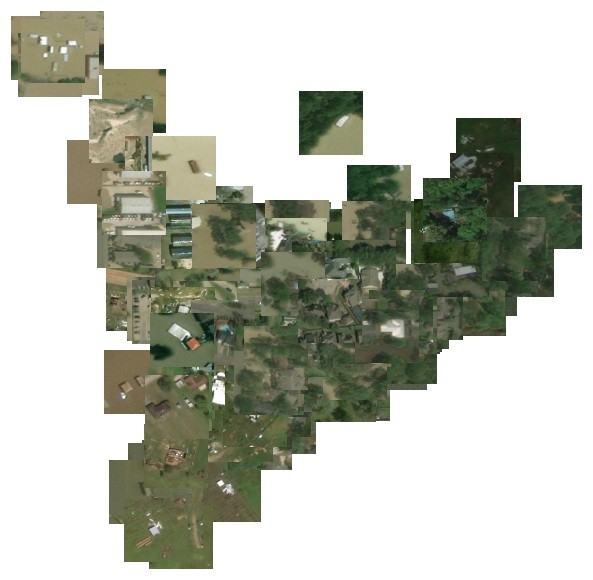

In [33]:
def show_xy_images(in_df, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    artists = []
    for _, c_row in in_df.iterrows():
        c_img = Image.open(c_row['path']).resize((64, 64))
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['x'], c_row['y']), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(in_df[['x', 'y']])
    ax.autoscale()
    ax.axis('off')
show_xy_images(image_df_all.sample(200))

In [34]:
image_df_all['path'] = image_df_all['path'].map(bstr) 
image_df_all.reset_index(inplace=True)
image_df_all.to_json('color_features.json')

#### 3D PCA

In [112]:
xyz_pca = PCA(n_components=3)
xyz_coords = xyz_pca.fit_transform(combined_col_features)
image_df_all['x1'] = xyz_coords[:, 0]
image_df_all['y1'] = xyz_coords[:, 1]
image_df_all['z1'] = xyz_coords[:, 2]

In [113]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(image_df_all, x='x1', y='y1', z='z1',color='damage')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

### 2.4.2 Features from pre-trained models
Acquired features from a pretrained model, in this case resnet50. These features will provide information about shape, corners and much more complicated features.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications import resnet50
from tensorflow.keras import models, layers

pretrained_model = resnet50.ResNet50(include_top=False, weights='imagenet')
feature_model = models.Sequential(name='just_features')
prep_layer = layers.Conv2D(3, 
                           kernel_size=(1, 1), 
                           weights=[np.expand_dims(np.expand_dims(np.eye(3), 0), 0), 
                                    np.array([-103.9, -116.78, -123.68])],
                           input_shape=(None, None, 3),
                          name='PreprocessingLayer')
feature_model.add(prep_layer)
feature_model.add(pretrained_model)
feature_model.add(layers.GlobalAveragePooling2D())
feature_model.save('feature_model.h5')
feature_model.summary()

In [37]:
%%time
image_df_all['resnet_features'] = image_df_all['path'].progress_map(lambda x: feature_model.predict(np.expand_dims(imread(x), 0))[0])

100%|███████████████████████████████████| 23000/23000 [2:45:59<00:00,  2.31it/s]

CPU times: user 1h 9min 40s, sys: 12min 17s, total: 1h 21min 57s
Wall time: 2h 45min 59s


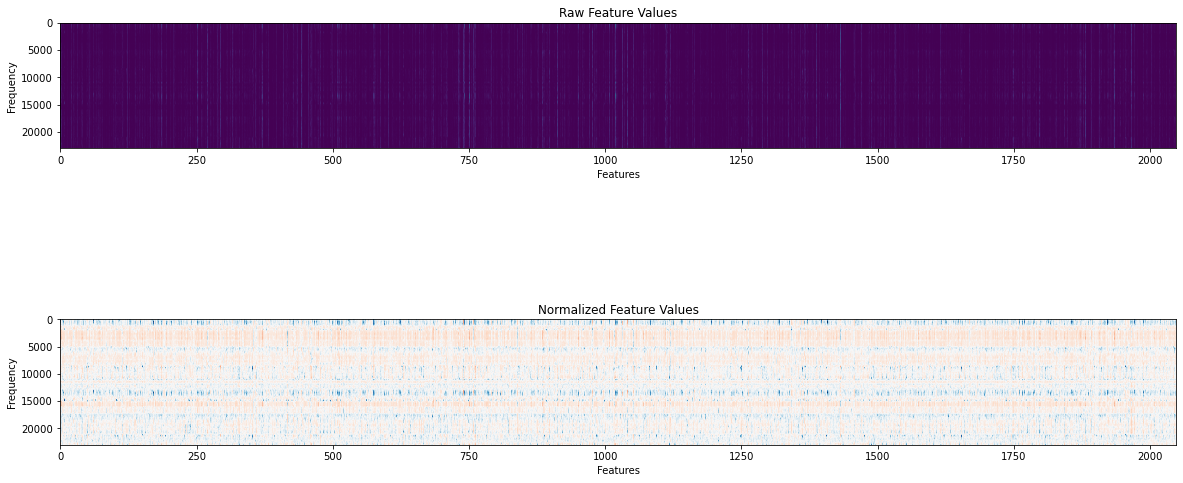

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
combined_resnet_features = np.stack(image_df_all['resnet_features'].values, 0)
ax[0].imshow(combined_resnet_features)
ax[0].set_title('Raw Feature Values')
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Frequency')
ax[0].set_aspect(0.01)
color_wise_average = np.tile(np.mean(combined_resnet_features, 0, keepdims=True), (combined_resnet_features.shape[0], 1))
color_wise_std = np.tile(np.std(combined_resnet_features, 0, keepdims=True), (combined_resnet_features.shape[0], 1)).clip(0.01, 10)
ax[1].imshow((combined_resnet_features-color_wise_average)/color_wise_std, vmin=-2, vmax=2, cmap='RdBu')
ax[1].set_title('Normalized Feature Values')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Frequency')
ax[1].set_aspect(0.01)

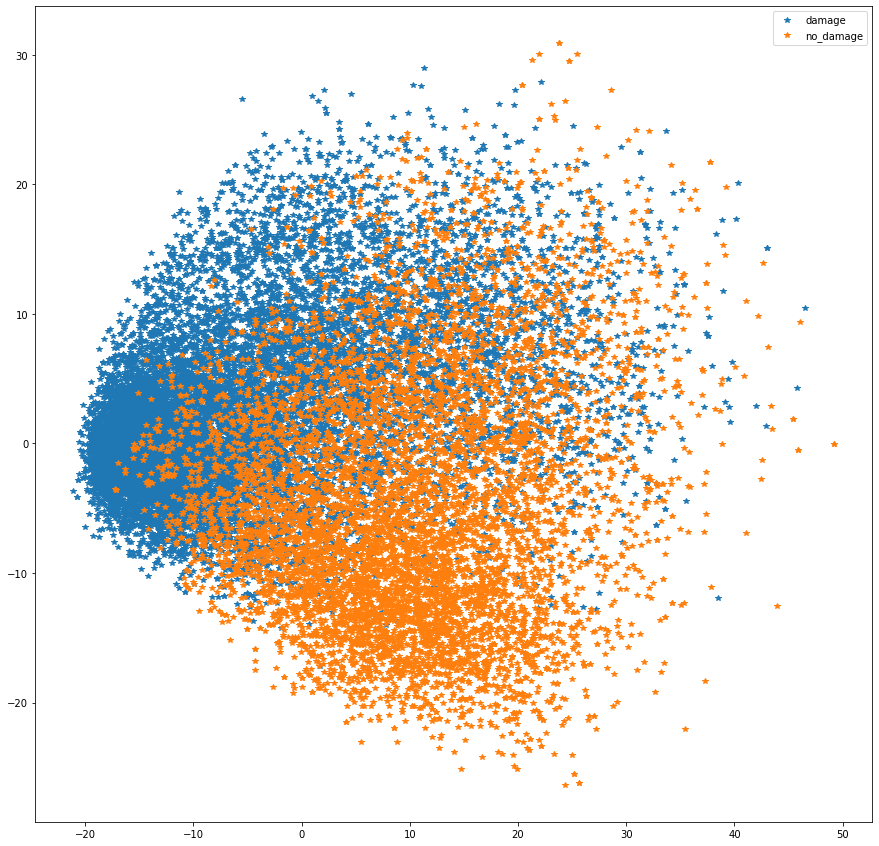

In [115]:
xy_pca = PCA(n_components=2)
xy_coords = xy_pca.fit_transform(combined_resnet_features)
image_df_all['x'] = xy_coords[:, 0]
image_df_all['y'] = xy_coords[:, 1]

fig, ax = plt.subplots(1,1, figsize=(15, 15))
for c_group, c_row in image_df_all.groupby('damage'):
    ax.plot(c_row['x'], c_row['y'], '*', label=c_group)
ax.legend()

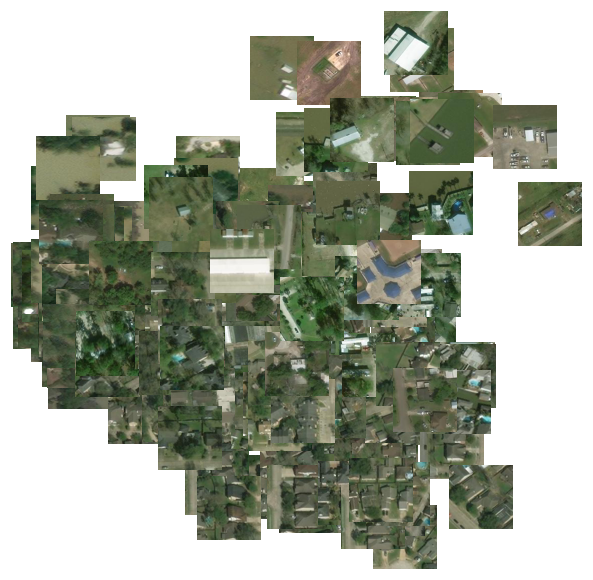

In [42]:
show_xy_images(image_df_all.groupby('damage').apply(lambda x: x.sample(100)))

#### 3D PCA

In [116]:
xyz_pca = PCA(n_components=3)
xyz_coords = xyz_pca.fit_transform(combined_resnet_features)
image_df_all['x1'] = xyz_coords[:, 0]
image_df_all['y1'] = xyz_coords[:, 1]
image_df_all['z1'] = xyz_coords[:, 2]

In [119]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(image_df_all, x='x1', y='y1', z='z1',color='damage')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

## 1.5 Summary

In this notebook, we've done some exploration of the datasets including:
- Converted some of the images to gray and see the reduction in size.
- Checked size consistency of the images in the datasets. All the images are of the same size (128x128x3)
- Extracted features related to color from all the images. We run 2D and 3D PCA analysis and examine if we can see clear separation of the damaged vs non-damaged images. The observation is that there is no clear separation b/n damaged and non-damaged imaged by using the color only features.
- Instead of using only color features, we need more features to separate the two classes. We extracted features from already trained models, in this case RESNET50. 
- After extracting features from RESNET50, simlar PCA analysis was done. There seem to be a good separation b/n the two classes of images. In the next notebook, we will start building models using these features

## 1.6 Save data

In [120]:
image_df_all.to_csv('./data/All_images_with_features.csv')